In [27]:
# uncomment these lines to pip-install required dependencies
# !pip install matplotlib
# !pip install numpy

# Übung 1: Nearest Centroid Classification

In dieser Übung sollen Sie selbst den Nearest Centroid Classification Algorithmus in Python programmieren.

In [34]:
import matplotlib.pylab as pl
import numpy as np
from numpy.random import multivariate_normal as mvn

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pl.rcParams['figure.figsize'] = (3.0, 3.0)

In [39]:
a = np.array([1,2,3,4,5])
b = np.array([5,4,3,2,1])

b[a == 2]

for i in b:
    for j in a:
        if b == a:
            return b

array([4])

## Python Version

Bitte wählen Sie die von Ihnen verwendete Python-Version aus!

[ ] 3.8

[ ] 3.9

[x] 3.10

## Data Generation Functions

Die folgenden Funktionen generieren künstliche Datensätze:
- two class data set with spherical covariance (uncorrelated data)
- two class data set with non-spherical covariance (correlated data)
- three class data set with non-spherical covariance (correlated data)

Sie können den Code gerne studieren. Sie müssen ihn aber nicht verstehen! Der Code muss ausgeführt werden, damit die Funktionen zur Benutzung verfügbar sind.

In [29]:
def make_data_threeclass(N=90):
    mu = np.array([[0,3],[0,-3],[2,1]]).T
    C = np.array([[5.,4.],[4.,5.]])
    n_samples_per_class = int(N/3)
    X = np.hstack((
        mvn(mu[:,0],C,n_samples_per_class).T,
        mvn(mu[:,1],C,n_samples_per_class).T,
        mvn(mu[:,2],C,n_samples_per_class).T))
    labels = np.ones(n_samples_per_class, dtype=int)
    y = np.hstack((labels,2*labels,3*labels))-1
    # generates some toy data
    return X.T,y.T


def make_data_twoclass(N=100):
    # generates some toy data
    mu = np.array([[0, 3], [0, -3]]).T
    n_samples_per_class = int(N/2)
    C = np.array([[5., 4.], [4., 5.]])
    X = np.hstack((
            mvn(mu[:, 0], C, n_samples_per_class).T, 
            mvn(mu[:, 1], C, n_samples_per_class).T
        ))
    y = np.hstack((np.zeros((n_samples_per_class)), (np.ones((n_samples_per_class)))))
    return X.T, y.T
    

def make_data_spherical(N=100):
    # generates some toy data
    mu = np.array([[0, 3], [0, -3]]).T
    n_samples_per_class = int(N/2)
    C = np.eye(2)
    X = np.hstack((
        mvn(mu[:, 0], C, n_samples_per_class).T, 
        mvn(mu[:, 1], C, n_samples_per_class).T
    ))
    y = np.hstack((np.zeros((n_samples_per_class)), (np.ones((n_samples_per_class)))))
    return X.T, y.T


def make_plot_nclass(X, y, classifier=None):
    colors = pl.cm.Set1.colors
    
    if classifier is not None:
        # Plot the decision boundary.
        h = .02 # stepsize in mesh
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = pl.contourf(xx, yy, Z, cmap=pl.cm.Pastel1, alpha=.6)

    # plot the data
    for class_idx, class_name in enumerate(np.unique(y)):
        idx = y == class_name
        pl.plot(X[idx, 0], X[idx, 1], c=colors[int(class_idx)], marker='.', linewidth=0)
        if classifier is not None:
            pl.plot(classifier.mu[class_idx, 0], 
                    classifier.mu[class_idx, 1], 
                    c=colors[int(class_idx)], 
                    marker='.',
                    markersize=20)

    pl.axis('tight')
    pl.xlabel('$X_1$')
    pl.ylabel('$X_2$')

## Beispiel: Datensatz visualisieren

Wir erzeugen 100 2D-Datenpunkte aus 2 Klassen mit unterschiedlichen Mittelwerten und sphärischer Kovarianz.

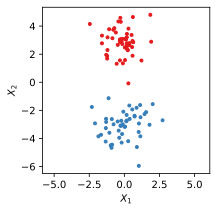

In [30]:
# generate some artificial data
X, y = make_data_spherical()
make_plot_nclass(X, y)
pl.axis('equal');

## Nearest Centroid Classification Algorithmus: Musterlösung

**A. Mit for-loop (über die Klassen)**

In [31]:
class NearestCentroidClassifier:
    """
    Multi-Class Implementation of the Nearest Centroid Classifier
    Labels of the classes are numbers and are stored implicitly in the index of `self.mu`.

    Attributes:
        mu: matrix with centroid per class, shape: len(classes) x len(features)
    """
    def __init__(self):
        self.mu = None

    def fit(self, X, y):
        """
        Compute the centroid per class and store in `self.mu`
        
        Args:
            X (numpy.ndarray): 2D data matrix (columns->features, rows->samples)
            y (numpy.ndarray): label vector
        
        Returns:
            None
            
        Raises:
            ValueError: if data is empty or number of samples and labels do not match
        """
        if X.size == 0:
            raise ValueError("data matrix is empty")
        if len(X) != len(y):
            raise ValueError(f"number of training samples ({len(X)}) does not match number of labels ({len(y)})")
        classes = np.unique(y) # find unique classes
        mu = np.zeros((len(classes), X.shape[1])) # prepare array for class-means
        for class_idx, class_label in enumerate(classes):
            mu[class_idx, :] = np.mean(X[y == class_label], axis=0)
        self.mu = mu
    
    def predict(self, X):
        """
        Perform nearest centroid prediction and obtain predicted labels

        Args: 
            X (numpy.ndarray): 2D data matrix (columns->features, rows->samples)

        Returns:
            numpy.ndarray: vector of predicted labels
            
        Raises:
            ValueError: if classifier is not fitted
        """
        if self.mu is None:
            raise ValueError("Classifier is not fitted, please call `self.fit` first!")
        distances = np.zeros((X.shape[0], self.mu.shape[0]))
        for centroid in np.arange(self.mu.shape[0]):
            distances[:, centroid] = np.sum((X - self.mu[centroid])**2, axis=1) # skip sqrt because min is not affected
        y_predicted = distances.argmin(axis=1)
        return y_predicted


**B. Ohne for-loops** 

In [ ]:
class NearestCentroidClassifier:
    """
    Multi-Class Implementation of the Nearest Centroid Classifier
    Labels of the classes are numbers and are stored implicitly in the index of `self.mu`.

    Attributes:
        mu: matrix with centroid per class, shape: len(classes) x len(features)
    """
    def __init__(self):
        self.mu = None

    def fit(self, X, y):
        """
        Compute the centroid per class and store in `self.mu`
        
        Args:
            X (numpy.ndarray): 2D data matrix (columns->features, rows->samples)
            y (numpy.ndarray): label vector
        
        Returns:
            None
            
        Raises:
            ValueError: if data is empty or number of samples and labels do not match
        """
        if X.size == 0:
            raise ValueError("data matrix is empty")
        if len(X) != len(y):
            raise ValueError(f"number of training samples ({len(X)}) does not match number of labels ({len(y)})")
        y_unique, y_unique_idx = np.unique(y, return_inverse=True)
        mu = np.zeros((y_unique.shape[0], X.shape[1]))
        np.add.at(mu, y.astype(int), X)
        mu /= np.bincount(y_unique_idx).reshape(-1, 1)
        self.mu = mu
    
    def predict(self, X):
        """
        Perform nearest centroid prediction and obtain predicted labels

        Args: 
            X (numpy.ndarray): 2D data matrix (columns->features, rows->samples)

        Returns:
            numpy.ndarray: vector of predicted labels
            
        Raises:
            ValueError: if classifier is not fitted
        """
        if self.mu is None:
            raise ValueError("Classifier is not fitted, please call `self.fit` first!")
        reshaped = X.reshape((X.shape[0], 1, X.shape[1])) # reshape for broadcasting
        norm = np.sum(np.square(reshaped - self.mu), axis=2) # skip sqrt because min is not affected
        y_predicted = np.argmin(norm, axis=1)
        return y_predicted

## Überprüfung

Im folgenden Code werden 3 ``NearestCentroidClassifier`` auf verschiedenen Datensätzen trainiert und getestet.
Wenn Ihre Implementierung stimmt, dann sollten Sie die Plots reproduzieren können!

CPU times: user 748 ms, sys: 180 ms, total: 928 ms
Wall time: 590 ms


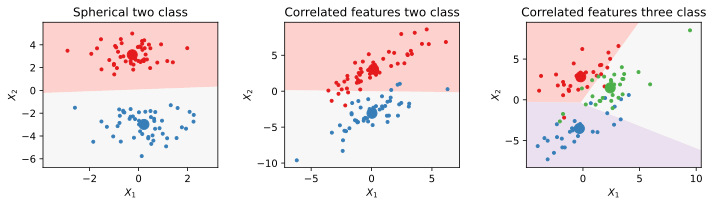

In [32]:
%%time

pl.figure(figsize=(10,3))

pl.subplot(1,3,1)
X1, y1 = make_data_spherical()
ncc1 = NearestCentroidClassifier()
ncc1.fit(X1, y1)
make_plot_nclass(X1, y1, ncc1)
pl.title('Spherical two class')

pl.subplot(1,3,2)
X2, y2 = make_data_twoclass()
ncc2 = NearestCentroidClassifier()
ncc2.fit(X2, y2)
make_plot_nclass(X2, y2, ncc2)
pl.title('Correlated features two class')

pl.subplot(1,3,3)
X3, y3 = make_data_threeclass()
ncc3 = NearestCentroidClassifier()
ncc3.fit(X3, y3)
make_plot_nclass(X3, y3, ncc3)
pl.title('Correlated features three class')

pl.tight_layout(w_pad=2)

In [33]:
N_CLASSES = 200
N_FEATURES = 20
N_SAMPLES = 10000

X = np.random.rand(N_SAMPLES, N_FEATURES)
y = np.random.randint(0, N_CLASSES-1, N_SAMPLES)

ncc = NearestCentroidClassifier()
%time ncc.fit(X, y)
%time ncc.predict(X)

CPU times: user 9.81 ms, sys: 579 µs, total: 10.4 ms
Wall time: 10.1 ms
CPU times: user 225 ms, sys: 0 ns, total: 225 ms
Wall time: 224 ms


array([  5, 172,  62, ..., 196,  70,  42])